In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

root
 |-- m1: double (nullable = true)
 |-- m2: double (nullable = true)
 |-- n1: double (nullable = true)
 |-- n2: double (nullable = true)
 |-- shape: string (nullable = true)
 |-- m: double (nullable = true)
 |-- n: double (nullable = true)

+---+---+---+---+-----------+------------------+------------------+
| m1| m2| n1| n2|      shape|                 m|                 n|
+---+---+---+---+-----------+------------------+------------------+
|5.1|3.5|1.4|0.2|Iris-setosa| 6.185466837676846| 1.414213562373095|
|4.9|3.0|1.4|0.2|Iris-setosa| 5.745432968889291| 1.414213562373095|
|4.7|3.2|1.3|0.2|Iris-setosa|   5.6859475903318|1.3152946437965907|
|4.6|3.1|1.5|0.2|Iris-setosa|5.5470712993434645|1.5132745950421556|
|5.0|3.6|1.4|0.2|Iris-setosa| 6.161168720299745| 1.414213562373095|
|5.4|3.9|1.7|0.4|Iris-setosa| 6.661080993352356| 1.746424919657298|
|4.6|3.4|1.4|0.3|Iris-setosa| 5.720139858430037|1.4317821063276353|
|5.0|3.4|1.5|0.2|Iris-setosa|  6.04648658313239|1.5132745950421556|
|4.4|2.

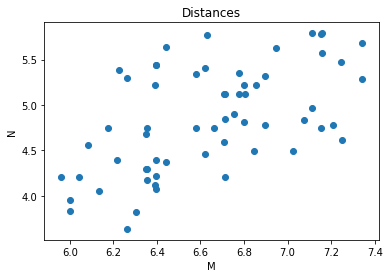

In [10]:
# -*- coding: utf-8 -*-

import os
import matplotlib.pylab as plt
import math
import numpy
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *


class Utils():
    def __init__(self):
        pass

    # 敘述性統計：平均數 標準差
    def getStatValue(self, df, fieldName):
        stat = df.select(avg(fieldName), stddev(fieldName)).collect()
        return stat[0]

class LoadSavedData(Utils):
    # 繼承
    def __init__(self):
        Utils.__init__(self)

    # 載入資料集檔案
    def loadData(self, dataFile):
        sql = 'SELECT * FROM parquet.`%s`' % dataFile
        df = sqlContext.sql(sql)
        return df

    # 列印敘述性統計
    def printStats(self, df, fields=None):
        if fields is None:
            df.describe().show()
        else:
            for field in fields:
                df.describe(field).show()

    # 繪製散佈圖
    def plotScatter(self, df, x, y, title=None, xLabel=None, yLabel=None):
        # 轉換為 Pandas 資料格式
        pdf = df.toPandas()

        plt.scatter(pdf[[x]], pdf[[y]])

        if title is not None:
            plt.title(title)

        if title is not None:
            plt.title(title)

        if xLabel is not None:
            plt.xlabel(xLabel)

        if yLabel is not None:
            plt.ylabel(yLabel)

        plt.show()


# 計算衍生欄位值
def distance(x, y):
    result = math.sqrt(x**2 + y**2)
    return result


# 主程式
def main(dataDir):
    # 資料欄位名稱
    fields = ['m1', 'm2', 'n1', 'n2', 'shape']

    # 類別初始化
    worker = LoadSavedData()

    # 載入資料集
    df = worker.loadData(dataFile='%s/iris.parquet' % dataDir)

    # 自訂函數：對照轉換欄位相應值
    myUdf = udf(distance, DoubleType())

    # 對照轉換欄位相應值，衍生新欄位，取代原資料集
    df = df.withColumn('m', myUdf('m1', 'm2')).withColumn('n', myUdf('n1', 'n2'))

    # 列印資料集綱要
    df.printSchema()
    df.show()
    # 列印敘述性統計：平均數 標準差
    for field in ['m', 'n']:
        stat = worker.getStatValue(df, field)
        print('%8s\t%.3f\t%.3f' % (field, stat[0], stat[1]))

    m = numpy.array(df.select('m').collect())
    n = numpy.array(df.select('n').collect())

    m_mean = m.mean()
    m_std = m.std()
    # 用numpy計算平均值mean() 標準差std()
    n_mean = n.mean()
    n_std = n.std()

    m_mean2 = df.select(avg('m')).collect()
    m_std2 = df.select(stddev('m')).collect()
    n_mean2 = df.select(avg('n')).collect()
    n_std2 = df.select(stddev('n')).collect()
    # 用dataframe計算平均值avg() 標準差stddenv()

    df = df.where((col('m') > m_mean - m_std) & (col('m') < m_mean + m_std)).\
            where((col('n') > n_mean - n_std) & (col('n') < n_mean + n_std))

    # 繪製散佈圖
    worker.plotScatter(df, title='Distances',
                            x='m', xLabel='M',
                            y='n', yLabel='N')

    # 保存資料集至指定目錄下
    df.write.mode('overwrite').save('%s/iris2.parquet' % dataDir,
                                        format='parquet')


# 程式進入點
if __name__ == '__main__':
    global sc, sqlContext

    # 本地資源運算
    appName = 'Cup-02'
    master = 'local'

    #sc = SparkContext(conf=SparkConf().setAppName(appName).setMaster(master))

    # 取得資料庫介面
    sqlContext = SQLContext(sc)

    # 調用主程式
    homeDir = os.environ['HOME']
    dirName = 'Data'
    sampleDir = '%s/Sample' % homeDir
    dataDir = '%s/Data' % homeDir

    main(dataDir)
